# AllLife Bank Customer Segmentation
*by Garey Salinas*

<a id=top></a>
### Contents

- [Overview of Dataset](#overview)
- [Exploratory Data Analysis](#eda)
- [Data Preparation](#preparation)
- [K-Means Algorithm](#kmeans)
- [Hierarchal Clustering](#hierarchal)
- [Insights and Recommendations](#recommendations)

----

### Background

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer's queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

----

### Objective

To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

- Perform EDA.
- Apply Clustering Algorithms and mentions how many clusters are formed?
- How are these segments different from each other?
- What are your recommendations to the bank on how to better market to and service these customers?

----

### Data Description

Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call center.

----

### Import Libraries

In [60]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np
import math

from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from scipy.spatial.distance import cdist, pdist

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering 

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to suppress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

%matplotlib inline
sns.set()

<a id=overview></a>
## <span style="color:blue">Overview of Dataset</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [61]:
data = pd.read_excel('Credit Card Customer Data.xlsx')
df = data.copy()

In [62]:
df.shape

(660, 7)

In [63]:
df.columns

Index(['Sl_No', 'Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [64]:
pd.concat([df.head(), df.tail()])

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


In [65]:
df.columns = [col.replace(' ','_') for col in df.columns]
df.columns = [col.lower() for col in df.columns]

In [66]:
try:
    df.drop(['sl_no', 'customer_key'], axis=1, inplace=True)
except:
    print('columns already dropped.')

- Dropping the sl_no and customer_key columns since it doesnt contribute to the analysis.

In [67]:
df.columns

Index(['avg_credit_limit', 'total_credit_cards', 'total_visits_bank',
       'total_visits_online', 'total_calls_made'],
      dtype='object')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   avg_credit_limit     660 non-null    int64
 1   total_credit_cards   660 non-null    int64
 2   total_visits_bank    660 non-null    int64
 3   total_visits_online  660 non-null    int64
 4   total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


- all columns are of numerical type int.

In [69]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
avg_credit_limit,660.000,34574.242,37625.488,3000.000,10000.000,18000.000,48000.000,200000.000
total_credit_cards,660.000,4.706,2.168,1.000,3.000,5.000,6.000,10.000
total_visits_bank,660.000,2.403,1.632,0.000,1.000,2.000,4.000,5.000
total_visits_online,660.000,2.606,2.936,0.000,1.000,2.000,4.000,15.000
total_calls_made,660.000,3.583,2.865,0.000,1.000,3.000,5.000,10.000


- avg_credit_limit zero missing values with a mean of 34574 and standard deviation of 37625. Appears to be heavily right skewed with extreme outliers.
- total_credit_cards column has a mean of 4.7 with a standard deviation of 2.168. Values range from 1 to 10.
- total_visits_bank has a mean of 2.4 with a standard deviation of 1.632. Values range from 1 to 5.
- total_visits_online has a mean of 2.6 and standard deviation of 2.936. Values range from 1 to 15 and seems to be right skewed with some outliers to the upside.
- total_calls_made has a mean of 3.583 with a standard deviation of 2.865. Values range from 1 to 10.

In [70]:
df.isnull().sum()

avg_credit_limit       0
total_credit_cards     0
total_visits_bank      0
total_visits_online    0
total_calls_made       0
dtype: int64

In [71]:
df[df.duplicated()]

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
295,10000,6,4,2,3
324,9000,4,5,0,4
361,18000,6,3,1,4
378,12000,6,5,2,1
385,8000,7,4,2,0
395,5000,4,5,0,1
455,47000,6,2,0,4


<a id=eda></a>
## <span style="color:blue">Exploratory Data Analysis</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Univariate Analysis

In [72]:
def histogram_boxplot(feature, figsize=(15, 7), bins=None):
    """ 
    Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (15,10))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='yellow') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=True, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=True, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='blue', linestyle='-');# Add median to the histogram

In [73]:
def perc_on_bar(feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    #Creating a countplot for the feature
    sns.set(rc={'figure.figsize':(15,7)})
    ax=sns.countplot(x=feature, data=data, palette='mako')
    
    total = len(feature) # length of the column
    for p in ax.patches:
        # percentage of each class of the category
        percentage = 100 * p.get_height()/total
        percentage_label = f"{percentage:.1f}%"
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage_label, (x, y), size = 12) # annotate the percantage
        
    plt.show() # show the plot

In [74]:
df.columns

Index(['avg_credit_limit', 'total_credit_cards', 'total_visits_bank',
       'total_visits_online', 'total_calls_made'],
      dtype='object')

### avg_credit_limit

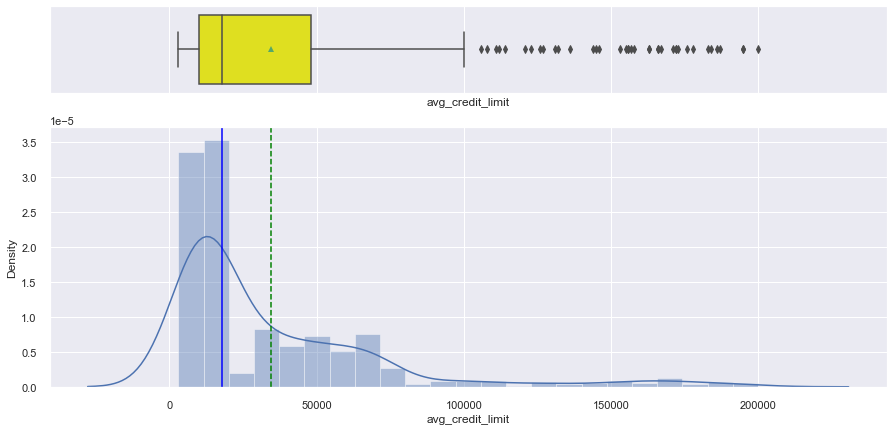

In [75]:
histogram_boxplot(df.avg_credit_limit)

### total_credit_cards

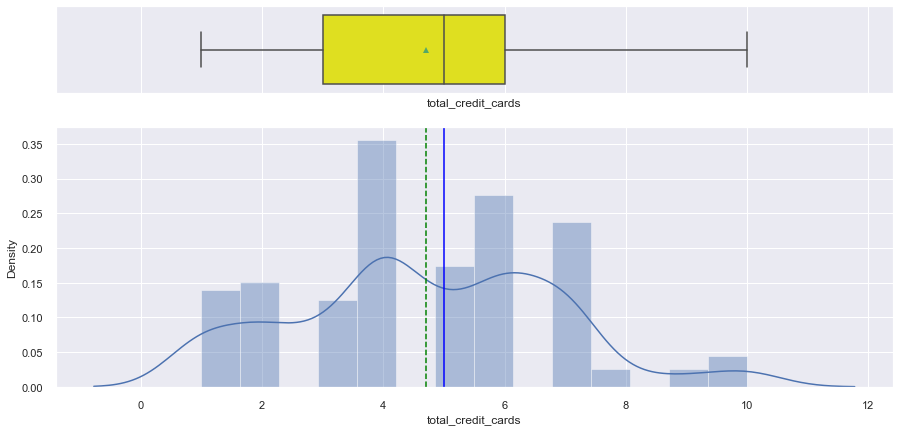

In [76]:
histogram_boxplot(df.total_credit_cards)

### total_visits_bank

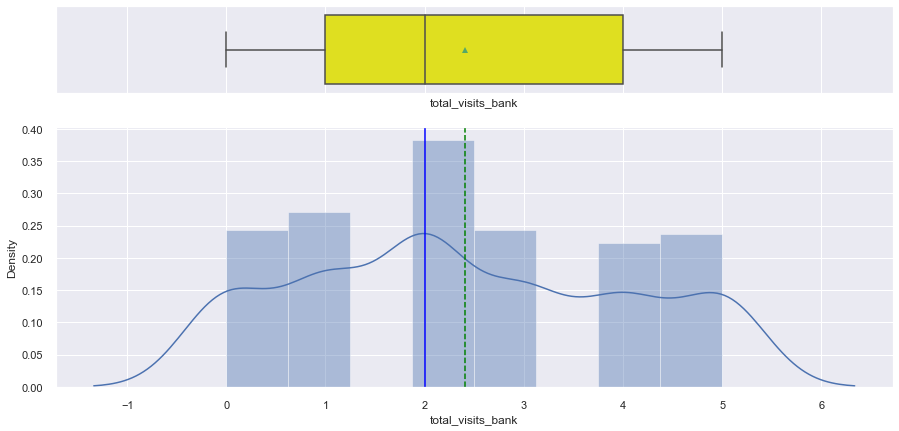

In [77]:
histogram_boxplot(df.total_visits_bank)

### total_visits_online

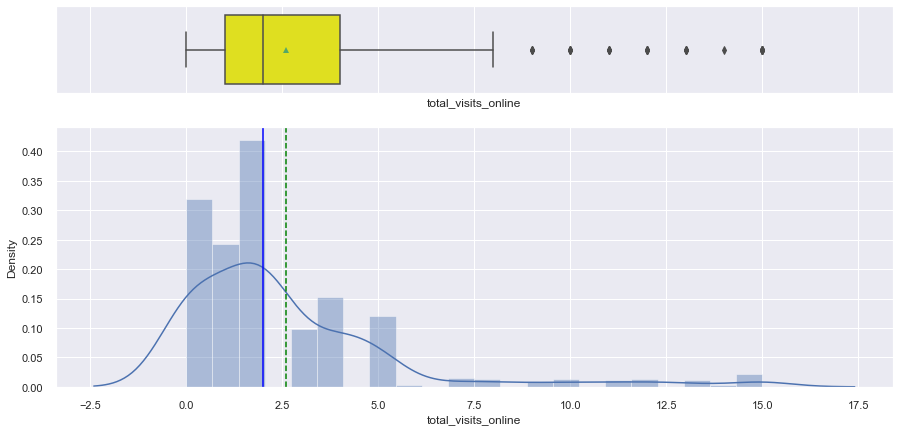

In [78]:
histogram_boxplot(df.total_visits_online)

### total_calls_made

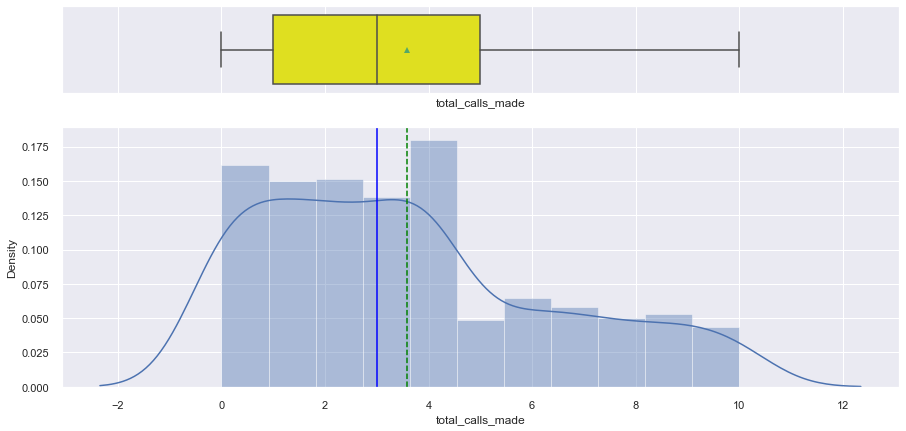

In [79]:
histogram_boxplot(df.total_calls_made)

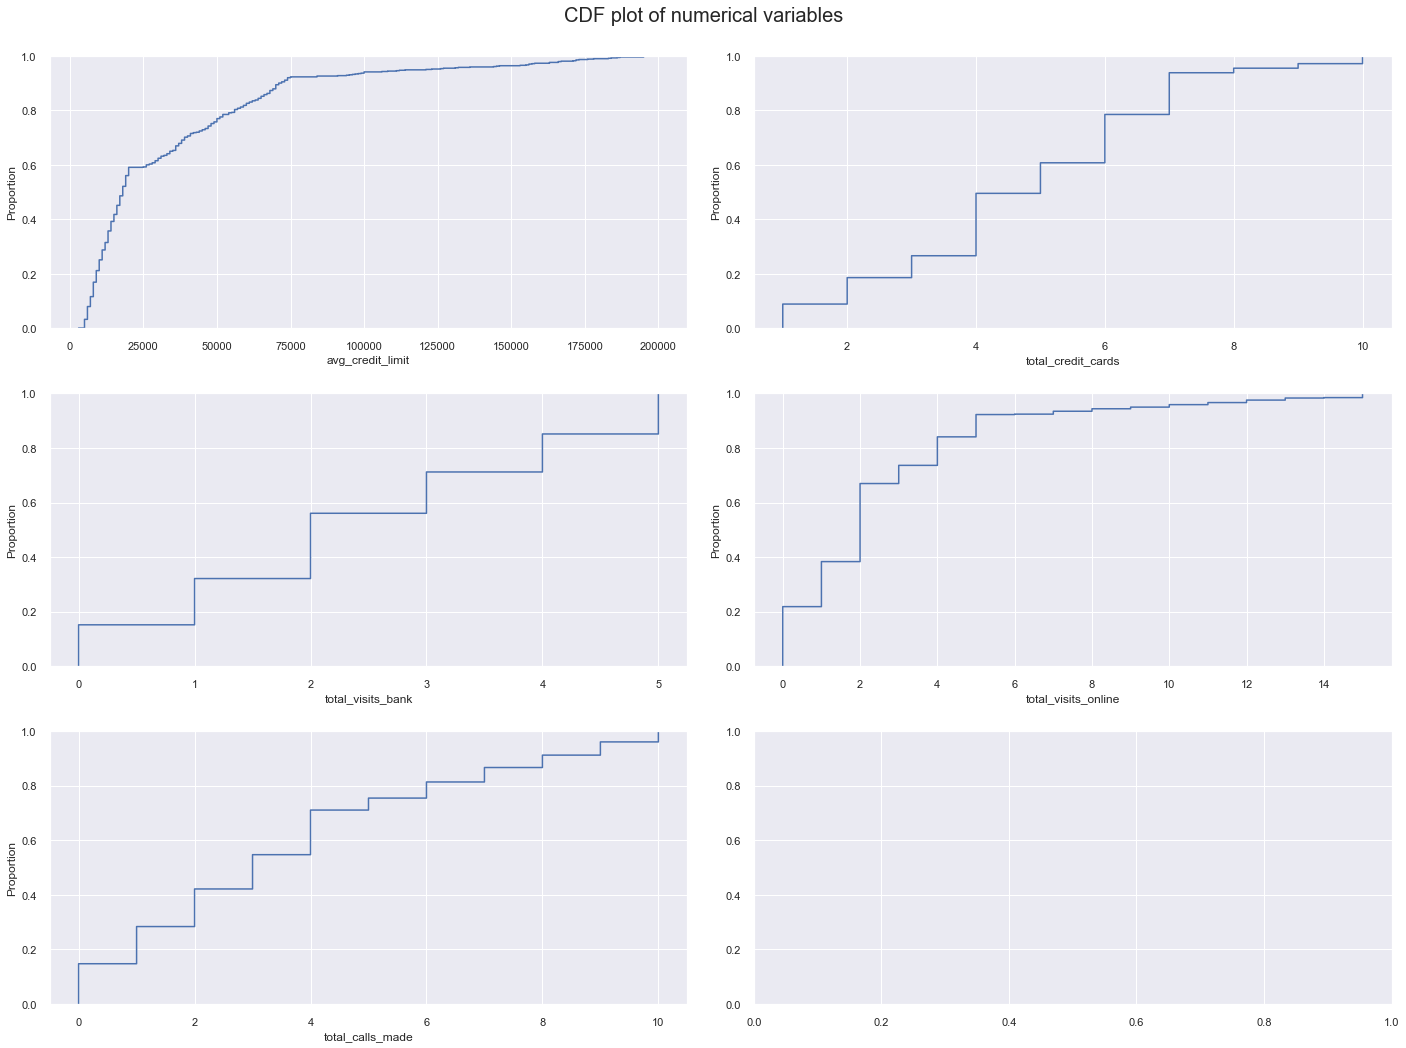

In [80]:
# select numerical columns
all_col = df.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(3, 2,  figsize=(20, 15))
fig.suptitle('CDF plot of numerical variables', fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0],x=df[all_col[counter]])
    counter = counter+1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1],x=df[all_col[counter]])
        counter = counter+1
    else:
        pass


fig.tight_layout(pad=2.0)

### Bivariate Analysis

### Heatmap

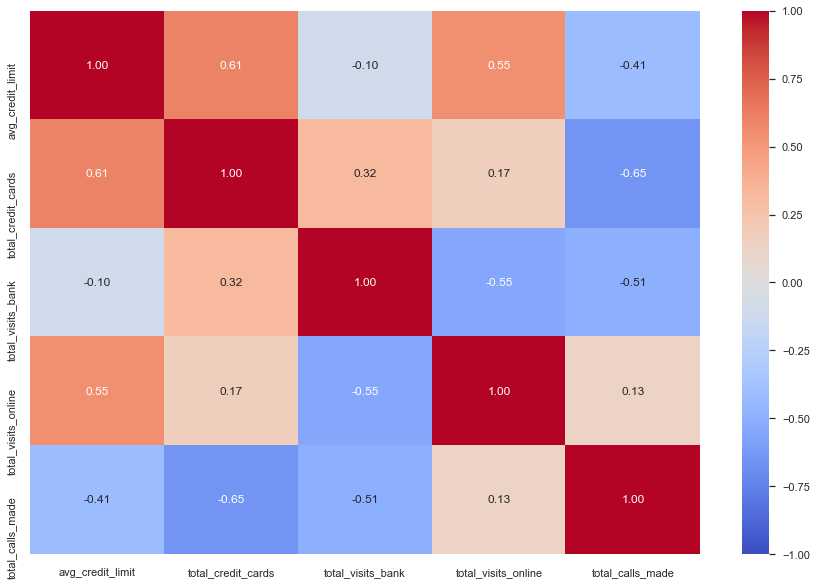

In [81]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='coolwarm');

- total_credit_cards and avg_credit_limit are positively correlated.
- total_visits_online and avg_credit_limit are positively correlated.
- total_credit_cards and total_calls_made are negatively correlated.
- total_visits_online and total_visits_bank are negatively correlated.
- total_calls_made and total_visits_bank are negatively correlated.

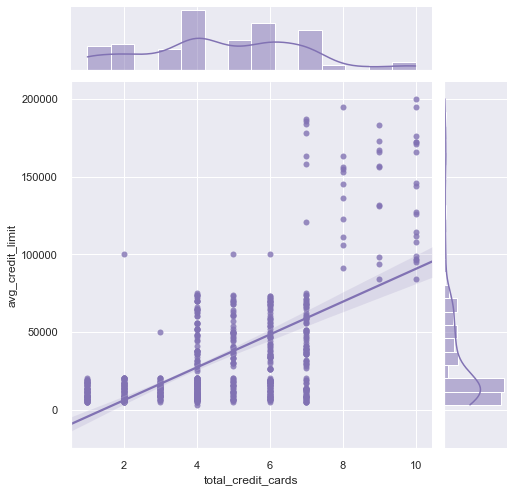

In [82]:
sns.jointplot(
    x="total_credit_cards", 
    y="avg_credit_limit",
    data=df,
    kind="reg",
    truncate=False,
    color="m", 
    height=7
);

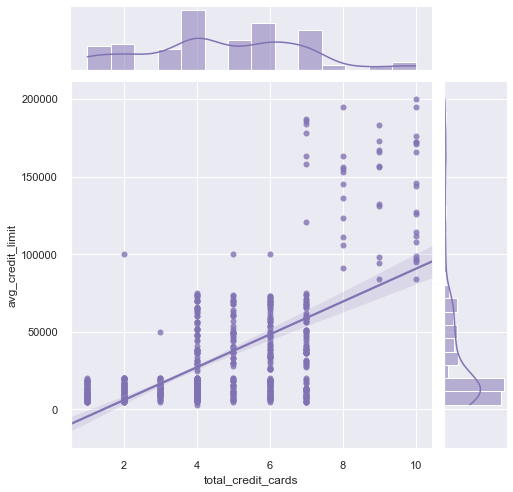

In [83]:
sns.jointplot(
    x="total_credit_cards", 
    y="avg_credit_limit",
    data=df,
    kind="reg",
    truncate=False,
    color="m", 
    height=7
);

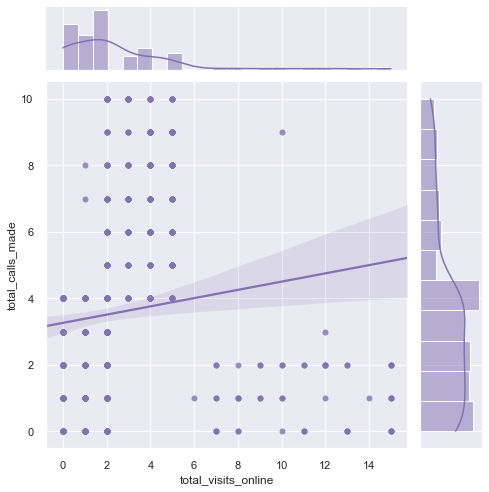

In [84]:
sns.jointplot(
    x="total_visits_online", 
    y="total_calls_made",
    data=df,
    kind="reg",
    truncate=False,
    color="m", 
    height=7
);

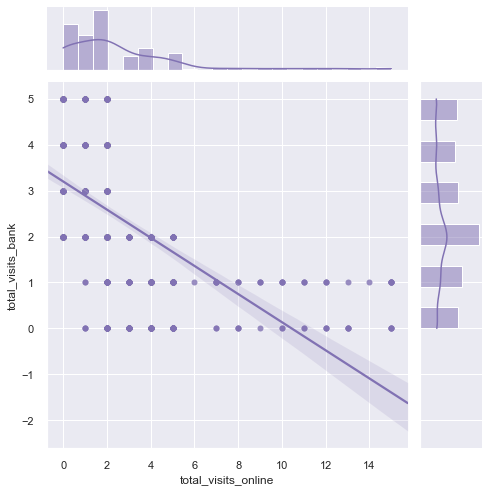

In [85]:
sns.jointplot(
    x="total_visits_online", 
    y="total_visits_bank",
    data=df,
    kind="reg",
    truncate=False,
    color="m", 
    height=7
);

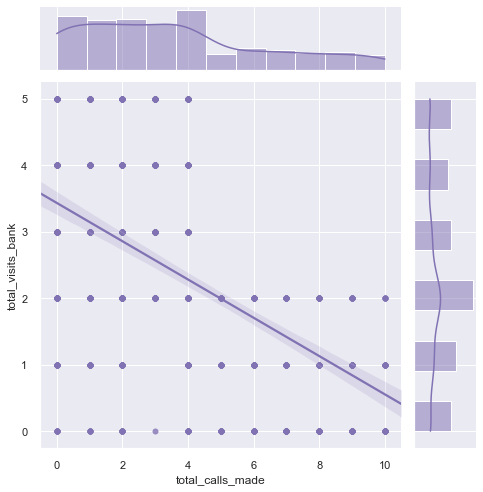

In [86]:
sns.jointplot(
    x="total_calls_made", 
    y="total_visits_bank",
    data=df,
    kind="reg",
    truncate=False,
    color="m", 
    height=7
);

### Pairplot

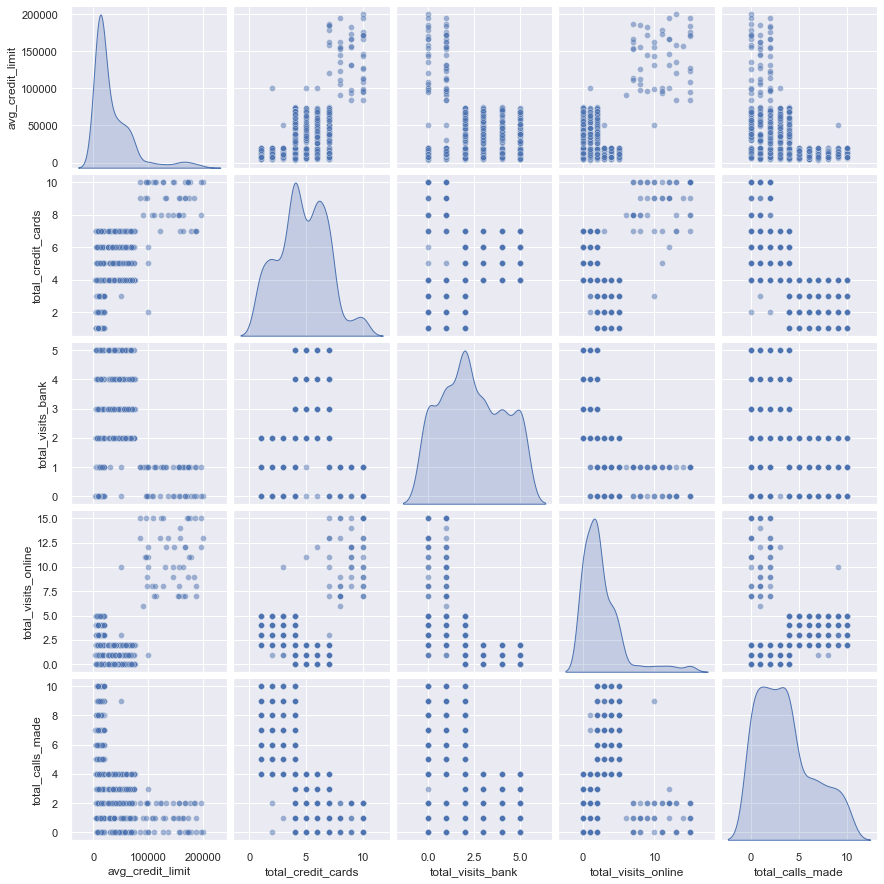

In [87]:
sns.pairplot(
    data=df, 
    palette='husl',
    diag_kind='kde',
    plot_kws={'alpha': 0.5}
);

- Plot of the all feature distributions.

<a id=kmeans></a>
## <span style="color:blue">K-Means Clustering</span>
<div style="text-align:right"><a href=#top>top</a></div>

We will use K-Means clustering to group data based on their attribute. First, we need to determine the optimal number of groups. For that we conduct the elbow test to see where the elbow happens.

In [88]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df.copy()
subset_scaled = scaler.fit_transform(subset)   

In [89]:
#Creating a dataframe from the scaled data above
scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)
scaled_df.head()

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
0,1.740,-1.249,-0.860,-0.547,-1.252
1,0.410,-0.788,-1.474,2.521,1.892
2,0.410,1.059,-0.860,0.134,0.146
3,-0.122,0.136,-0.860,-0.547,0.146
4,1.740,0.597,-1.474,3.202,-0.204


Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9430693962124551
Number of Clusters: 7 	Average Distortion: 0.9094107386188999
Number of Clusters: 8 	Average Distortion: 0.890406562479968


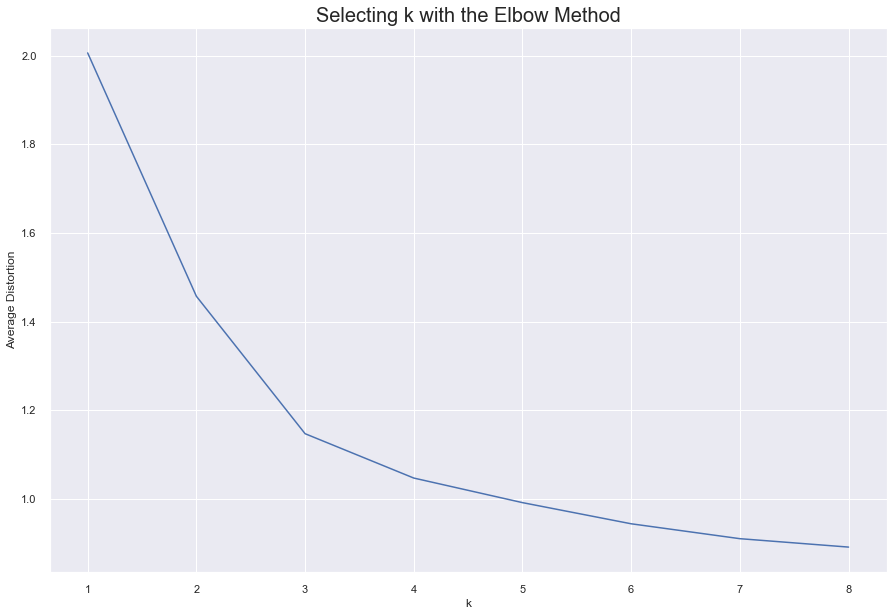

In [90]:
clusters = range(1,9)
mean_distortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(scaled_df)
    prediction = model.predict(scaled_df)
    distortion = sum(np.min(cdist(scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / scaled_df.shape[0]
                           
    mean_distortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)
plt.figure(figsize=(15,10))
plt.plot(clusters, mean_distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20);

- The appropriate value of k from the elbow curve above seems to be 3.

### Silhoutte Score

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.25545029453623114
For n_clusters = 7, silhouette score is 0.2486042710835614
For n_clusters = 8, silhouette score is 0.227266904385329
For n_clusters = 9, silhouette score is 0.21904474609467492


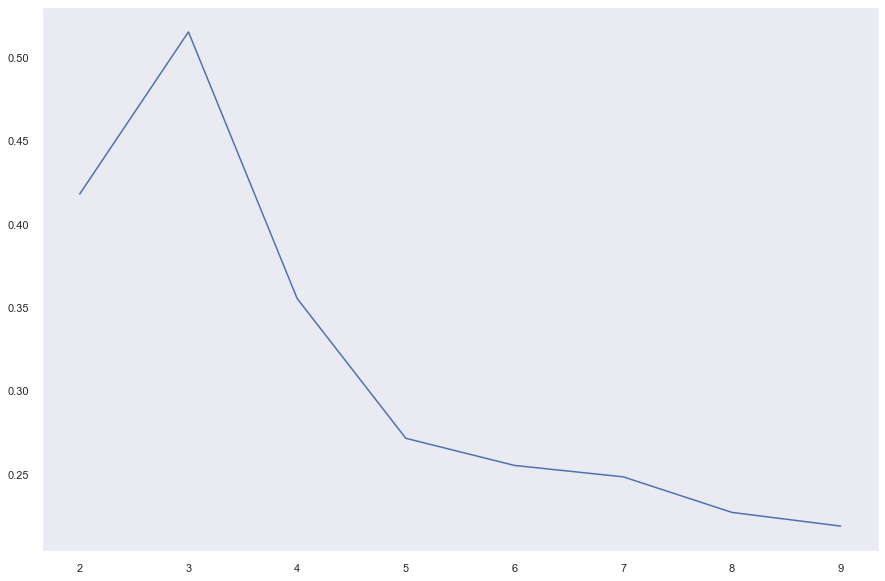

In [91]:
scores = []
clusters = list(range(2,10))
for cluster in clusters:
    clusterer = KMeans(n_clusters=cluster)
    preds = clusterer.fit_predict((scaled_df))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(scaled_df, preds)
    scores.append(score)
    print(f"For n_clusters = {cluster}, silhouette score is {score}")
plt.figure(figsize=(15, 10))
plt.plot(clusters, scores)
plt.grid();

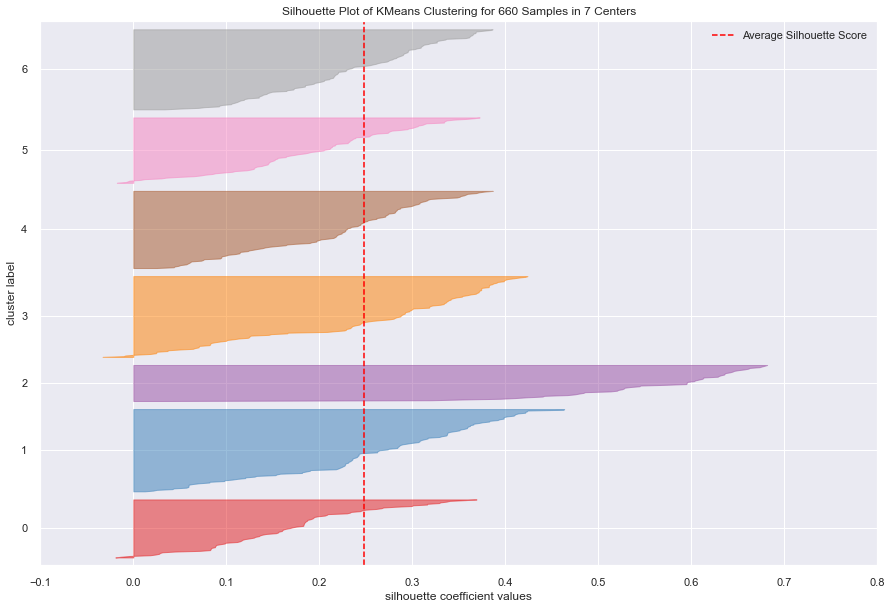

In [92]:
#Finding optimal no. of clusters with silhouette coefficients
plt.figure(figsize=(15,10))
visualizer = SilhouetteVisualizer(KMeans(7, random_state = 1))
visualizer.fit(scaled_df)    
visualizer.show();

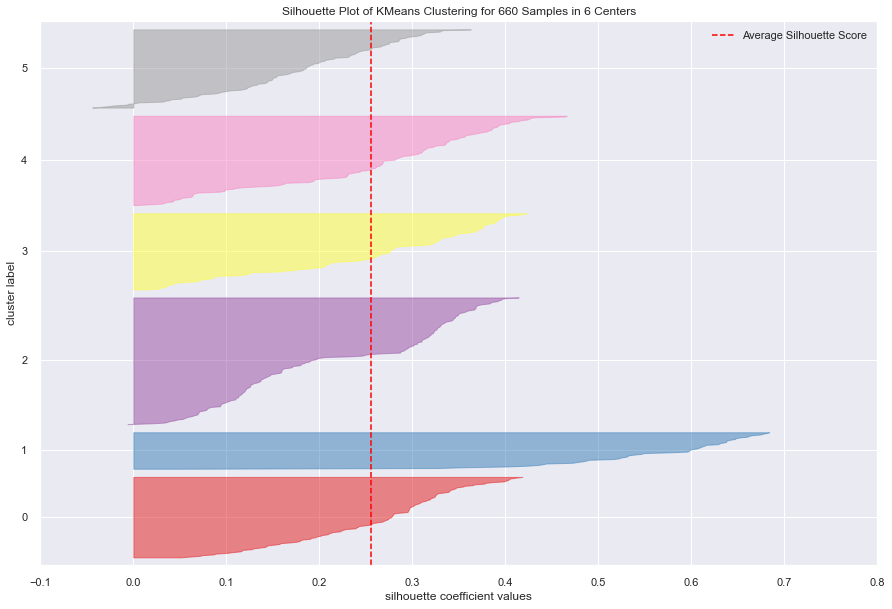

In [93]:
#Finding optimal no. of clusters with silhouette coefficients
plt.figure(figsize=(15,10))
visualizer = SilhouetteVisualizer(KMeans(6, random_state = 1))
visualizer.fit(scaled_df)    
visualizer.show();

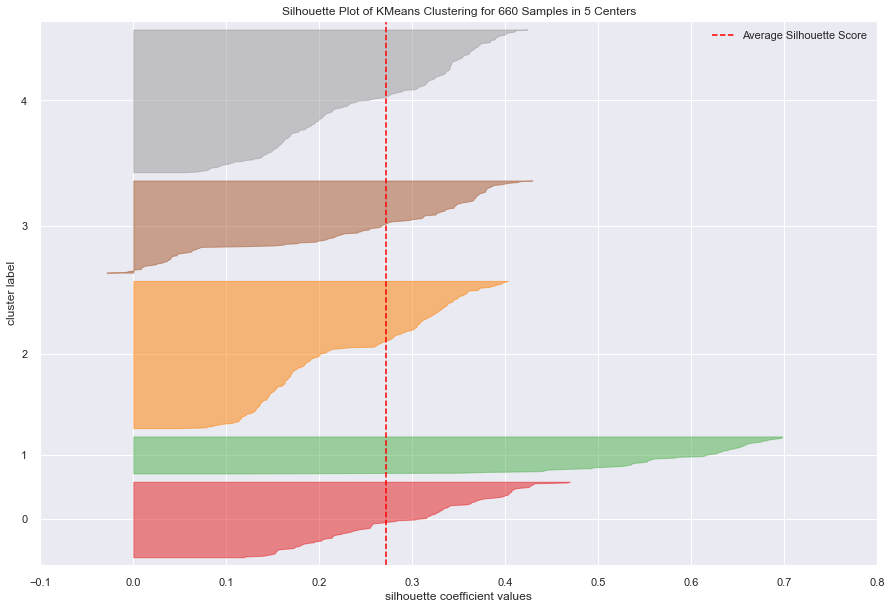

In [94]:
#Finding optimal no. of clusters with silhouette coefficients
plt.figure(figsize=(15,10))
visualizer = SilhouetteVisualizer(KMeans(5, random_state = 1))
visualizer.fit(scaled_df)    
visualizer.show();

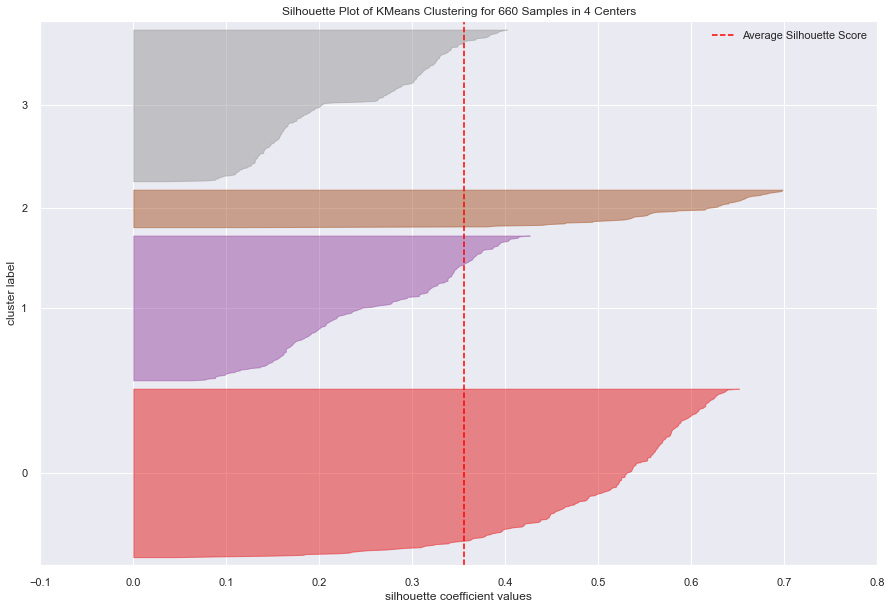

In [95]:
#Finding optimal no. of clusters with silhouette coefficients
plt.figure(figsize=(15, 10))
visualizer = SilhouetteVisualizer(KMeans(4, random_state = 1))
visualizer.fit(scaled_df)    
visualizer.show();

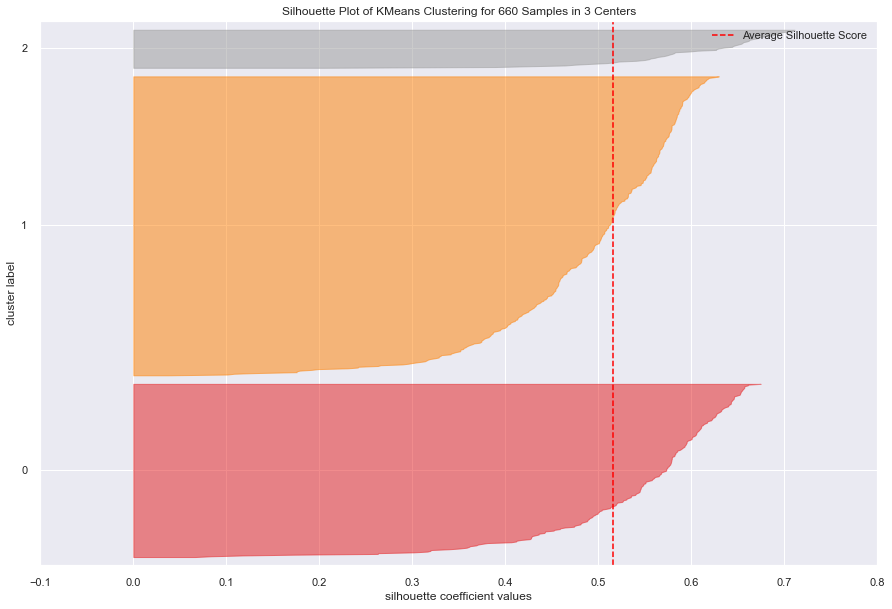

In [96]:
#Finding optimal no. of clusters with silhouette coefficients
plt.figure(figsize=(15,10))
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(scaled_df)    
visualizer.show();

- We will take 3 as the number of clusters as the silhoutte score is high and there is a defined elbow from the elbow plot.

In [97]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(scaled_df)

df['K_means_segments'] = kmeans.labels_

cluster_profile = df.groupby('K_means_segments').mean()
cluster_profile

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
K_means_segments,,,,,
0,33782.383,5.516,3.490,0.982,2.000
1,12174.107,2.411,0.933,3.554,6.871
2,141040.000,8.740,0.600,10.900,1.080


In [98]:
#df.groupby('K_means_segments').mean().plot.bar(figsize=(10, 15));

In [99]:
# lets display cluster profile
cluster_profile.style.highlight_max(color = 'lightgreen', axis = 0)

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
K_means_segments,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000
1,12174.107143,2.410714,0.933036,3.553571,6.870536
2,141040.000000,8.740000,0.600000,10.900000,1.080000


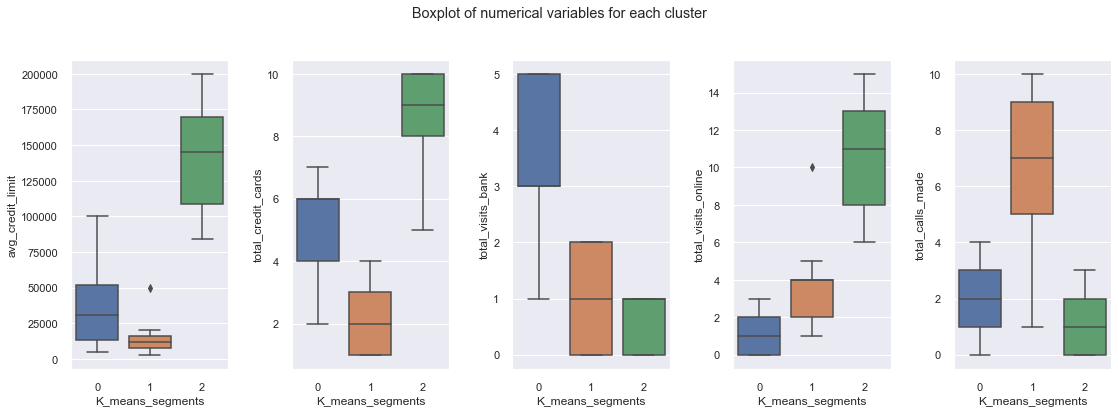

In [100]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster')
all_col = df.columns.tolist()
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[all_col[counter]], x=df['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

<a id=hierarchal></a>
## <span style="color:blue">Hierarchal Clustering</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [101]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
linkage_methods = ['single', 'complete', 'average', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(scaled_df))
        print(f'Cophent correlation for distance metrics {dm} and linkage method {lm} is {c:.3f}')
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm
print("*"*115)
print(f'Highest cophenet correlation is {high_cophenet_corr:.3f}, which is obtained with {high_dm_lm[0]} distance metric and {high_dm_lm[1]} linkage method')

Cophent correlation for distance metrics euclidean and linkage method single is 0.739
Cophent correlation for distance metrics euclidean and linkage method complete is 0.860
Cophent correlation for distance metrics euclidean and linkage method average is 0.898
Cophent correlation for distance metrics euclidean and linkage method weighted is 0.886
Cophent correlation for distance metrics chebyshev and linkage method single is 0.738
Cophent correlation for distance metrics chebyshev and linkage method complete is 0.853
Cophent correlation for distance metrics chebyshev and linkage method average is 0.897
Cophent correlation for distance metrics chebyshev and linkage method weighted is 0.891
Cophent correlation for distance metrics mahalanobis and linkage method single is 0.706
Cophent correlation for distance metrics mahalanobis and linkage method complete is 0.542
Cophent correlation for distance metrics mahalanobis and linkage method average is 0.833
Cophent correlation for distance me

In [102]:
linkage_methods = ['single', 'complete', 'average','median','ward', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]

for lm in linkage_methods:
    Z = linkage(scaled_df, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(scaled_df))
    print(f'Cophent correlation for distance metrics euclidean and linkage method {lm} is {c:.3f}')
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = dm
        high_dm_lm[1] = lm
print('*'*115)
print(f'Highest cophenet correlation is {high_cophenet_corr:.3f}, which is obtained with {high_dm_lm[0]} distance metric and {high_dm_lm[1]} linkage method')

Cophent correlation for distance metrics euclidean and linkage method single is 0.739
Cophent correlation for distance metrics euclidean and linkage method complete is 0.860
Cophent correlation for distance metrics euclidean and linkage method average is 0.898
Cophent correlation for distance metrics euclidean and linkage method median is 0.889
Cophent correlation for distance metrics euclidean and linkage method ward is 0.742
Cophent correlation for distance metrics euclidean and linkage method weighted is 0.886
*******************************************************************************************************************
Highest cophenet correlation is 0.898, which is obtained with cityblock distance metric and average linkage method


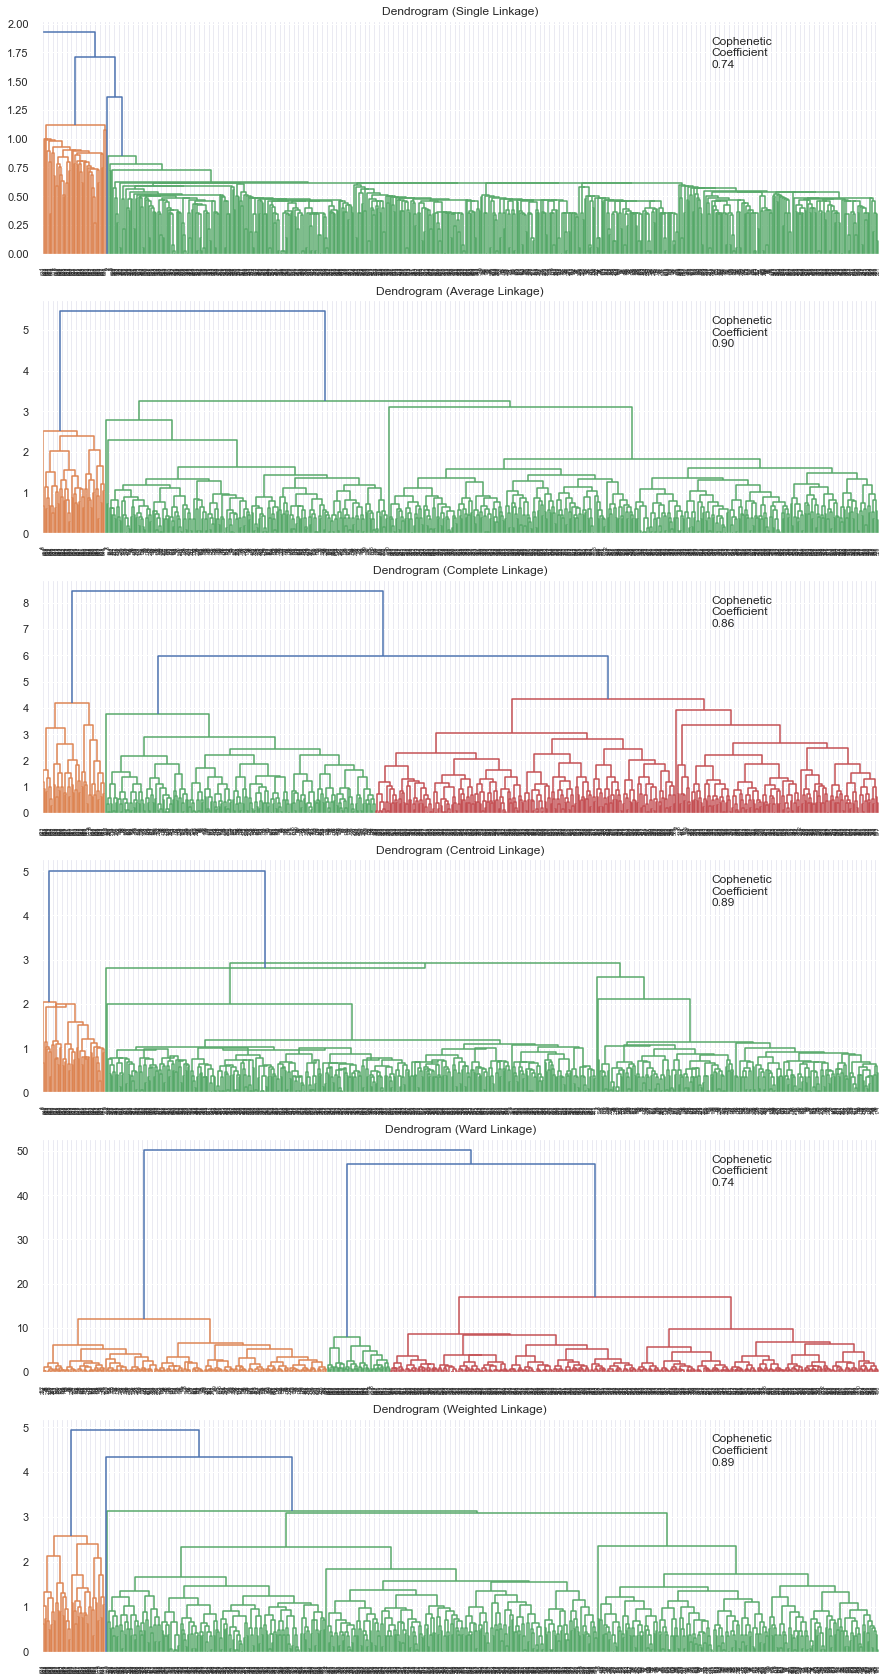

In [103]:
# List of all linkage methods to check
methods = [
    'single',
    'average', 
    'complete',
    'centroid',
    'ward',
    'weighted'
]

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    Z = linkage(scaled_df, metric='euclidean', method=method)
    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(scaled_df))
    axs[i].annotate(
        f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
        (0.80, 0.80),
        xycoords='axes fraction'
    )
    compare.append([method, coph_corr])

In [104]:
# Create and print dataframe to compare Cophenetic Coefficient for each linkage
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc.sort_values(by='Cophenetic Coefficient', ascending=False)

,Linkage,Cophenetic Coefficient
1,average,0.898
3,centroid,0.894
5,weighted,0.886
2,complete,0.860
4,ward,0.742
0,single,0.739


- 3 cluster would be appropriate number of cluster from dendrogram with ward linkage method  

In [105]:
distance_metrics = [ 'mahalanobis','cityblock']
linkage_methods = ['average', 'weighted']

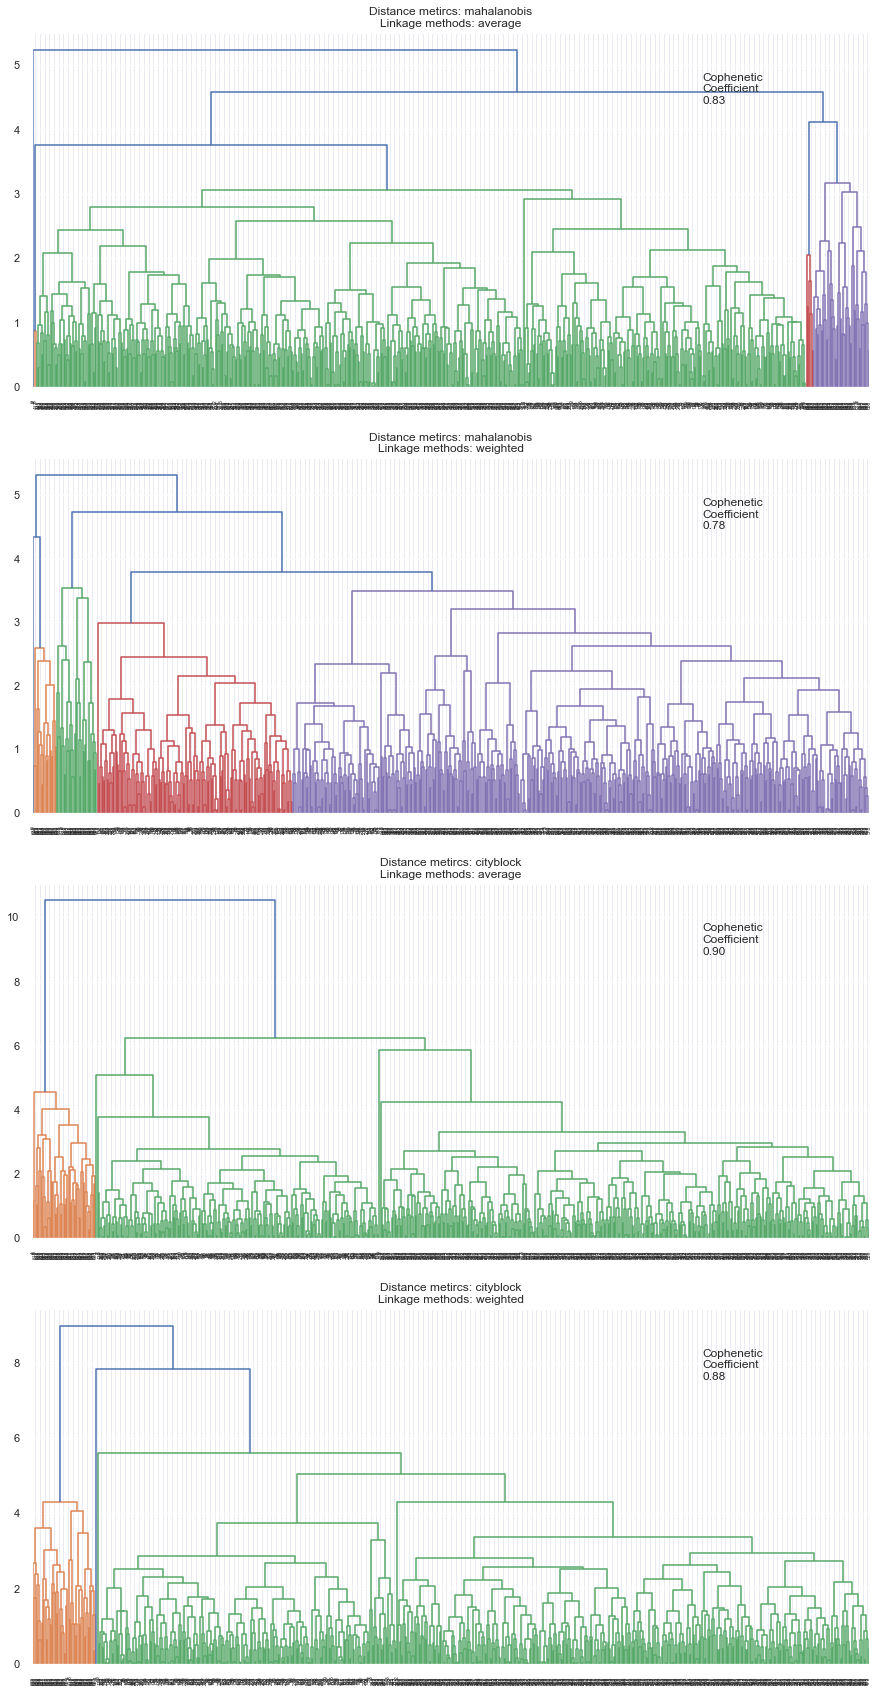

In [106]:
# Create a subplot image
fig, axs = plt.subplots(len(distance_metrics) + len(distance_metrics), 1, figsize=(15,30))
i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(scaled_df, metric=dm, method=lm)
        dendrogram(Z, ax=axs[i]);
        axs[i].set_title(f'Distance metircs: {dm}\nLinkage methods: {lm}')
        coph_corr, coph_dist = cophenet(Z, pdist(scaled_df))
        axs[i].annotate(
            f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
            (0.80, 0.80),
            xycoords='axes fraction'
        )
        axs[i].set_title(f'Distance metircs: {dm}\nLinkage methods: {lm}')                        
        i += 1

In [107]:
#Trying with K value as 3
HCmodel = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
HCmodel.fit(scaled_df)
scaled_df['HC_Clusters'] = HCmodel.labels_

In [108]:
df['HC_Clusters'] = HCmodel.labels_
cluster_profile = df.groupby('HC_Clusters').mean()
cluster_profile['count_in_each_segments'] = df.groupby('HC_Clusters')['avg_credit_limit'].count().values

# lets display cluster profile
cluster_profile.style.highlight_max(color = 'lightgreen', axis = 0)

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,33851.948052,5.516883,3.493506,0.979221,1.994805,0.000000,385
1,12151.111111,2.422222,0.937778,3.546667,6.857778,0.995556,225
2,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50


In [109]:
pca = PCA()
pca.fit(scaled_df)

PCA()

In [110]:
# Show variance explained by individual components
pca.explained_variance_ratio_

array([0.43077502, 0.40330426, 0.05958469, 0.05193922, 0.04589829,
       0.00849853])

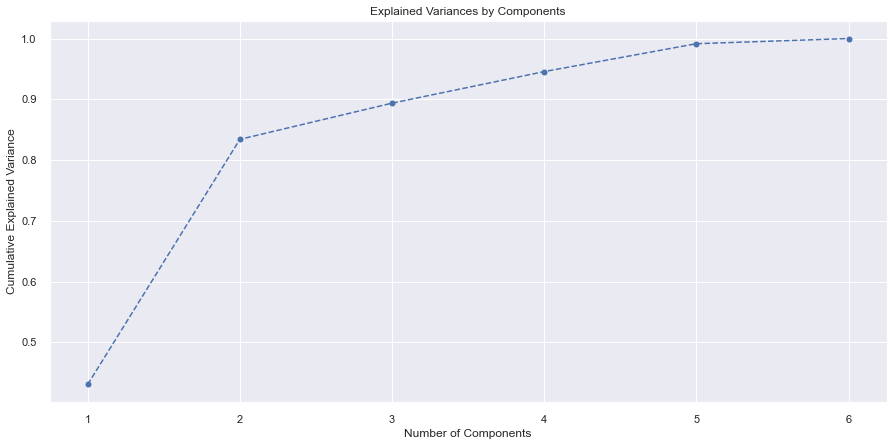

In [111]:
# visulaize the Explained Individual Components
plt.figure(figsize = (15, 7))
plt.plot(range(1, 7), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance");

**Observations**
- for 90% variance , the number of components should be 3

In [112]:
pca = PCA(.9, svd_solver ='full') # svd_solver -full helps to converge faster in case of very large data set
pca.fit(scaled_df)

PCA(n_components=0.9, svd_solver='full')

In [113]:
subset_pca = pca.transform(scaled_df)
subset_pca = pd.DataFrame(subset_pca)
subset_pca

,0,1,2,3
0,-0.356,0.494,1.926,-1.111
1,2.657,2.075,-0.842,-0.271
2,-0.256,0.756,0.209,1.119
3,0.253,-0.227,0.644,0.776
4,0.696,4.112,-0.127,-0.538
...,...,...,...,...
655,-1.279,4.090,-0.126,0.439
656,-0.587,4.440,-0.897,0.428
657,-0.989,4.263,0.025,-0.296
658,-1.522,6.203,-0.610,-0.539


In [114]:
dff = scaled_df.drop('HC_Clusters', axis=1)
dff

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
0,1.740,-1.249,-0.860,-0.547,-1.252
1,0.410,-0.788,-1.474,2.521,1.892
2,0.410,1.059,-0.860,0.134,0.146
3,-0.122,0.136,-0.860,-0.547,0.146
4,1.740,0.597,-1.474,3.202,-0.204
...,...,...,...,...,...
655,1.714,2.444,-0.860,2.521,-1.252
656,1.315,2.444,-0.860,3.543,-0.553
657,2.937,1.521,-0.860,2.180,-0.902
658,3.655,2.444,-0.860,4.225,-1.252


In [115]:
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hc_labels = hc.fit_predict(subset_pca)

dff['PCA_HC_clusters'] = hc_labels
cluster_profile2 = dff.groupby('PCA_HC_clusters').mean()
cluster_profile2

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
PCA_HC_clusters,,,,,
0,-0.019,0.374,0.669,-0.555,-0.555
1,-0.596,-1.054,-0.899,0.321,1.144
2,2.832,1.862,-1.106,2.827,-0.874


In [116]:
cluster_profile2.style.highlight_max(color = 'lightgreen', axis = 0)

,avg_credit_limit,total_credit_cards,total_visits_bank,total_visits_online,total_calls_made
PCA_HC_clusters,,,,,
0,-0.019212,0.374308,0.668767,-0.554573,-0.554819
1,-0.596408,-1.054310,-0.898610,0.320643,1.143653
2,2.831764,1.862226,-1.105763,2.827319,-0.874330


In [117]:
all_col = ['avg_credit_limit', 'total_credit_cards', 'total_visits_bank',
           'total_visits_online', 'total_calls_made']

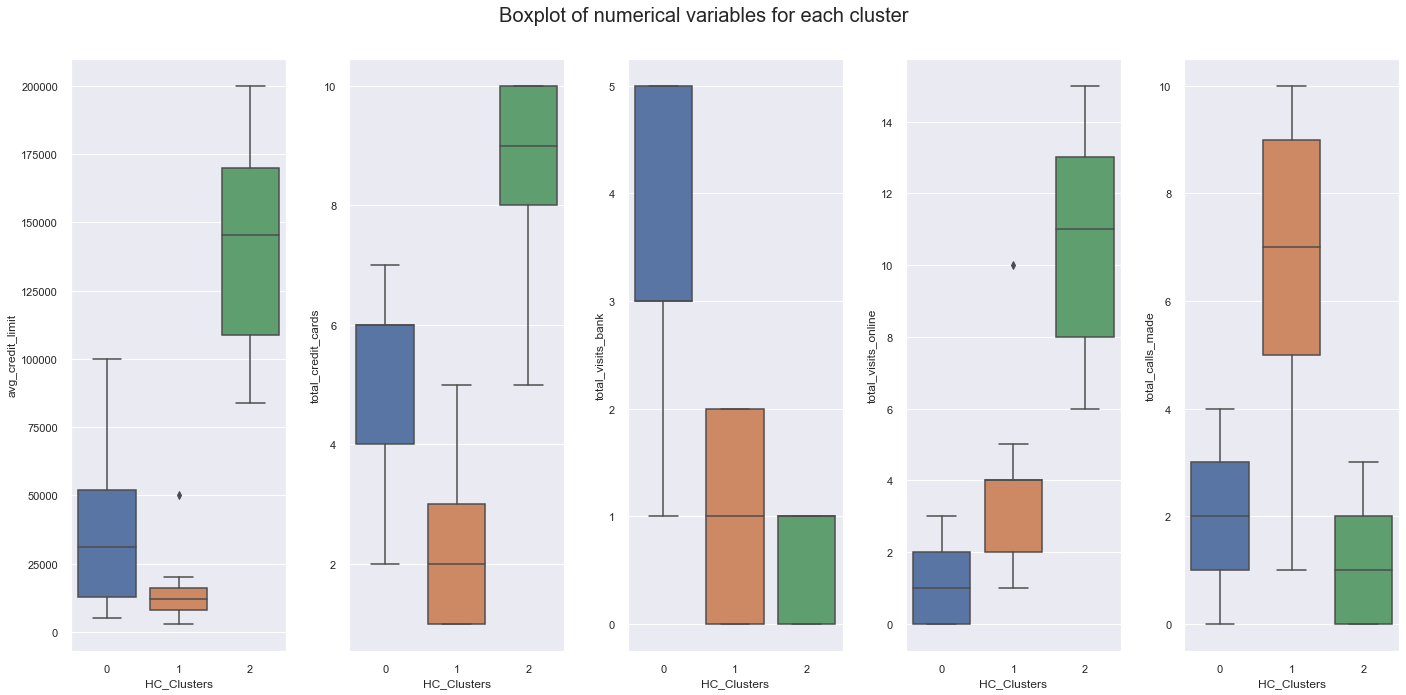

In [118]:
fig, axes = plt.subplots(1, 5,  figsize=(20, 10))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

<a id=recommendations></a>
## <span style="color:blue">Insights and Recommendations</span>
<div style="text-align:right"><a href=#top>top</a></div>

**Insights**
- Clusters 0 :
    - avg. credit limit is around 35,000 with the highest avg. credit limit at around 100,000.
    - total credit cards spread is range from 2 to about 7 total credit cards.
    - total visits to the bank range from 1 to 5 in this cluster.
    - total visits online average value is 1 with a spread ranging from 0 to 3 in this cluster.
    - total calls made on average is 2 and the spread ranges from 0 to 4.
- Cluster 1 :
    - avg. credit limit is around 10,000 with with a spread ranging from about 0 to 25,000. There is/are extreme ouliers to the upside at around 50,000.
    - total credit cards average value is 2 and the spread ranges from 0 to 4. 
    - total visits to the bank on average is 1 with a spread ranging from 0 to 2. 
    - total visits online has a spread ranging from 1 to 5.
    - total calls made on average is 7 and the spread ranges from 1 to 10.
- Cluster 2 :
    - avg. credit limit on average is 150,000 and the spread ranges from about 85,000 to 200,000.
    - total credit cards average value is 9 and the spread ranges from 5 to 10. 
    - total visits to the bank on average is low and can either be 0 or 1. 
    - total visits online on average is about 11 and the spread is from 6 to about 15.
    - total calls made is low and on average is 1 with a spread ranging from 0 to 3.

**Recommendations**
- Cluster 2 customers should be targeted due to higher credit limits and because of the higher number of credit cards used by those customers. Also, those customers in cluster 2 visit the bank less and make less calls, so in-house bank support can be minimized to help service those customers. However, Cluster 2 customers make more visits online so the bank's online services and support should be improved to help provide better online experience. 